In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.collections import LineCollection

import re
import sys
import os
import json

path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# sys.path.append("/home/kalmar/Mathematics/Software/Dionysus/build-x64/bindings/python/")
sys.path.append(os.path.join(path,"Dionysus-python3/build/bindings/python"))
import dionysus

%reload_ext autoreload
%autoreload 2

import TDA

In [30]:
# prefix = 'sampled-2000'
prefix = 'test'
pattern = re.compile('pair[0-9]{4,}$')
files = sorted([x for x in os.listdir(os.path.join(os.getcwd(),prefix)) if pattern.match(x)])
print(len(files))
print(files[:4])

2
['pair0001', 'pair0053']


In [37]:
i = 1
print(files[i])
directory = directory = os.path.join(os.getcwd(),prefix,files[i])
with open(os.path.join(directory,"diagrams_knn")) as file:
    diagrams = json.load(file)

pair0053


In [38]:
for key, value in diagrams[0].items():
    for i, pairs in enumerate(value): 
        print(key, "projection on", i ,"axis")
        print(pairs)

Y_inverted projection on 0 axis
[[0.35196040755343594, 0.5053381716991745]]
Y projection on 0 axis
[]
X projection on 0 axis
[[0.4859649849726475, 2.400454656129419], [0.9358949094603405, 1.1048869172518514]]
X projection on 1 axis
[]
X projection on 2 axis
[[0.36998671025849417, 0.47809300844420477]]
X_inverted projection on 0 axis
[]
X_inverted projection on 1 axis
[[0.08374243919000168, 0.5848043945748613], [0.23009491606797194, 0.33769456497659966], [0.6891342736235764, 1.0165956699645218]]
X_inverted projection on 2 axis
[[0.0854013954641295, 0.48499478285104924]]


In [39]:
class dummy:
    
    def __init__(self, diagrams):
        self.diagrams_list = diagrams
        self.create_persistence_diagrams()
    
    def create_persistence_diagrams(self):
        self.persistence_diagrams = []
        for dictionary in self.diagrams_list:
            dic = {}
            for key, projection in dictionary.items():
                proj = []
                for diagram in projection:
                    p_diagram = dionysus.PersistenceDiagram(0)
                    for pair in diagram:
                        p_diagram.append(tuple(pair))
                    proj.append(p_diagram)
                dic[key] = proj
            self.persistence_diagrams.append(dic)

In [40]:
x = dummy(diagrams)
x.persistence_diagrams[23]["X"][0]

2.28242 2.78158

In [41]:
len(x.persistence_diagrams)

30

In [42]:
diagrams[23]["X"][0]

[[2.2824180494677817, 2.7815797135632727]]

In [25]:
# for each in files[3:]:
#     p=Pair(prefix,each)

In [212]:
class PairResults():
    try:
        all_pairs_metadata = np.loadtxt(os.path.join(os.getcwd(), 'pairs', 'pairmeta.txt'))
    except FileNotFoundError:
        logging.warning("No metadata found! All is set to 0")
        all_pairs_metadata = np.zeros((88, 6))
    
    empty_diagram = dionysus.PersistenceDiagram(0)
    empty_diagram.append((0, 0))
    
    def __init__(self, name, path_to_diagrams, threshold=0):
        if name[-4:] == '.txt':
            name = name[:-4]
        self.name = name
        self.number = int(name[-4:])
        
        self.metadata = self.all_pairs_metadata[self.number-1]
        
        if self.metadata[1] == 1:     # i.e. X --> Y
            self.causality_true = 1  
        else:                         # i.e. Y --> X
            self.causality_true = -1  
        self.weight = self.metadata[5]
        
        self.x_range = range(int(self.metadata[2] - self.metadata[1]))
        self.y_range = range(int(self.metadata[4] - self.metadata[3]))
        
        with open(path_to_diagrams, 'r') as diagrams:
            self.persistence_list = json.load(diagrams)
        
        self.prepare_persistence_diagrams()

        self.causality_inferred = self.decide_causality()
    
    def prepare_persistence_diagrams(self):
        
        self.persistence_diagrams = self.turn_list_to_dionysus_p_diagrams(self.persistence_list)
        
        self.X_diagrams = [self.persistence_diagrams[i]["X"]
                           for i in range(len(self.persistence_diagrams))]
        self.Y_diagrams = [self.persistence_diagrams[i]["Y"]
                           for i in range(len(self.persistence_diagrams))]
        self.X_inv_diagrams = [self.persistence_diagrams[i]["X_inverted"] 
                               for i in range(len(self.persistence_diagrams))]
        self.Y_inv_diagrams = [self.persistence_diagrams[i]["Y_inverted"] 
                               for i in range(len(self.persistence_diagrams))]
    
    
    def turn_list_to_dionysus_p_diagrams(self, diagram_list):
        """
        diagrams_list should be a list of dictionaries indexed by outliers.
        dictionaries contain 4 keys:
        X
        X_inverted
        Y
        Y_inverted
        
        Content of every value is (again) a list of persistence diagrams 
        of projections to axes in x_range or y_range respectively.
        
        hence to acces persistence pairs of inverse filtration along the 2nd axis of X-variable
        after removing 10 outliers we need something like
        self.diagrams_list[10]['X_inverted'][2]
        
        return: the same list with the last leafs turned into dionysus.PersistenceDiagram
        """
        
        persistence_diagrams = []
        for dictionary in diagram_list:
            dic = {}
            for key, projection in dictionary.items():
                proj = []
                for diagram in projection:
                    p_diagram = dionysus.PersistenceDiagram(0)
                    if not diagram:
                        diagram = [(0,0)]
                    for pair in diagram:
                        p_diagram.append(tuple(pair))
                    proj.append(p_diagram)
                dic[key] = proj
            persistence_diagrams.append(dic)
        return persistence_diagrams
                
        
    def compute_score(self, list_of_persistence_diags, p=0):
        """
        Computes score for a given list of diagrams
        input: persistence_diags_of_projections: one entry of self.{X,Y}_{inv}_diagrams
        return: list of scores
        """
        scores = []
        
        for diagram in list_of_persistence_diags:
            scores.append(self.distance(diagram, p))
        result = max(scores)
                          
        return result
                
    def compute_score_stability(self, persistence_diagrams, p=0):
        """
        input: all the diagrams of projections on a single axis (indexed by outliers)
        return: list of scores for each outlier_removal
        """
        stability = []
        for i in persistence_diagrams:
            stability.append(self.compute_score(i))
        return stability
    
    def decide_causality(self, threshold=0):
        """
        returns: 0 (undecided)
                 1 (X->Y)
                -1 (Y->X)
        """

        self.X_dist = np.array(self.compute_score_stability(self.X_diagrams))
        self.X_inv_dist = np.array(self.compute_score_stability(self.X_inv_diagrams))

        self.Y_dist = np.array(self.compute_score_stability(self.Y_diagrams))
        self.Y_inv_dist = np.array(self.compute_score_stability(self.Y_inv_diagrams))
                          
        l = self.X_dist.shape[0]
        weighting_function = lambda x: 1.0 + 0*x
#         weighting_function = lambda x: (-np.abs(x - l/2) + l/2)
#         weighting_function = lambda x: np.exp(-np.power(x - l/2, 2.) / (2 * np.power(l/6, 2.)))
        
        domain = np.arange(0,l,1)
        w = weighting_function(domain)
        weighting = w/sum(w)
        
        X_integral = np.dot(np.maximum(self.X_dist, self.X_inv_dist), weighting)
        Y_integral = np.dot(np.maximum(self.Y_dist, self.Y_inv_dist), weighting)
        
        self.confidence = np.abs(X_integral - Y_integral)
                          
        if self.confidence <= threshold:
            causality = 0
        else:
            causality = int((Y_integral - X_integral)/np.abs(X_integral - Y_integral))
        
        return causality
    
    def distance(self, persistence_diagram, p=0):
        """Returns p-th Wasserstein distance between the filtration's 0-diagram
        and the empty diagram.
        If p=0 then the bottleneck is returned.

        TODO: higher dimensions"""

        if p > 0:
            return dionysus.wasserstein_distance(
                persistence_diagram, self.empty_diagram, p)
        else:
            return dionysus.bottleneck_distance(
                persistence_diagram, self.empty_diagram)
    

In [213]:
class AnalysisOfResults:
        
    def __init__(self, prefix='test', threshold=0, outlier_model='knn'):
        
        pattern = re.compile('pair[0-9]{4,}$')
        prefix_path = os.path.join(os.getcwd(),prefix)
        dir_list = sorted([x for x in os.listdir(prefix_path) if pattern.match(x)])
        self.pairs = []
        
        for directory in dir_list:
            pair_dir = os.path.join(os.getcwd(),prefix,directory)
            if outlier_model == 'knn':
                path_to_diagrams = os.path.join(pair_dir,"diagrams_knn")
            elif outlier_model == 'all':
                path_to_diagrams = os.path.join(pair_dir,"diagrams_all")
            else:
                logging.warning("Results for model: %s not computed in %s",
                                str(outlier_model), str(outlier_model))
        
            self.pairs.append(PairResults(directory,path_to_diagrams))
        
        self.update_pairs_vectors(0)
        self.all_weighted_efficiency = self.weighted_efficiency()
        
        self.update_pairs_vectors(threshold)

    def update_pairs_vectors(self, threshold):
        self.pairs.sort(key=lambda x: x.confidence, reverse=True)
        
        self.pairs_decided = [x for x in self.pairs if x.decide_causality(threshold) != 0]
        self.decisions_vector = [x.causality_inferred for x in self.pairs_decided]

        self.decisions_got_right = [x.causality_inferred == x.causality_true 
                                    for x in self.pairs_decided]
        self.weighted_decisions = [x.weight*(x.causality_inferred == x.causality_true)
                                       for x in self.pairs_decided]
        
        self.all_weights = [x.weight for x in self.pairs_decided]

    def weighted_efficiency(self):
        weighted_efficiency = []
        for i in range(1,len(self.pairs)):
            entry = sum(self.weighted_decisions[:i])/sum(self.all_weights[:i])
            weighted_efficiency.append(entry)
        return weighted_efficiency
        
def accuracy_plot(X, weighted_efficiency, max):
    plt.plot(X.all_weighted_efficiency, color = 'black', alpha=0.3)
    to_plot = weighted_efficiency[:max]
    plt.plot(to_plot, color='blue', alpha=0.6)
    plt.ylim(0,1.05)
    print("Decisions taken:", max)
    print("Final accuracy rate:", to_plot[max-2])

Decisions taken: 83
Final accuracy rate: 0.696255072464


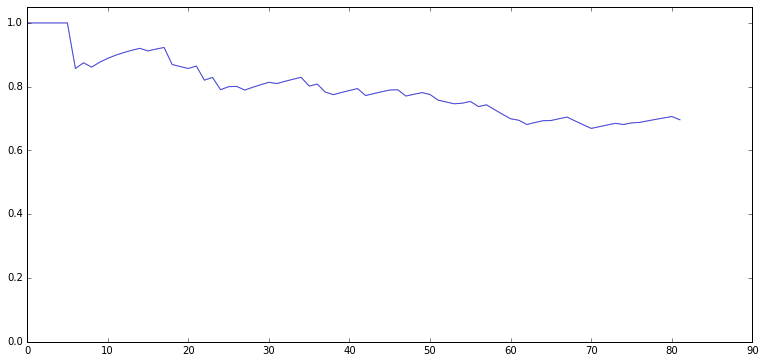

None

In [214]:
from IPython.html.widgets import widget, interact, interactive, fixed, FloatSlider, Dropdown

X = AnalysisOfResults(prefix="sampled-1000", threshold=0.0, outlier_model='knn')

@interact(threshold = (0,1,0.01))
def dummy(threshold):
    fig = plt.figure(figsize=(12,12))
    fig.set_size_inches(13,6) 
#     Y = AnalysisOfResults(files, prefix, threshold, outlier_model='all')
#     Y.plot(threshold)
    X.update_pairs_vectors(threshold)
    accuracy_plot(X, X.weighted_efficiency(), len(X.decisions_vector))
    plt.show()

Decisions taken: 83
Final accuracy rate: 0.676931884058


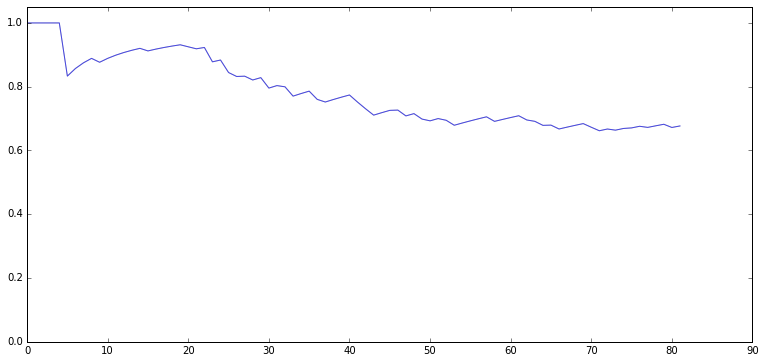

None

In [166]:
from IPython.html.widgets import widget, interact, interactive, fixed, FloatSlider, Dropdown

X = AnalysisOfResults(prefix="sampled-600", threshold=0.0, outlier_model='knn')

@interact(threshold = (0,1,0.01))
def dummy(threshold):
    fig = plt.figure(figsize=(12,12))
    fig.set_size_inches(13,6) 
#     Y = AnalysisOfResults(files, prefix, threshold, outlier_model='all')
#     Y.plot(threshold)
    X.update_pairs_vectors(threshold)
    accuracy_plot(X, X.weighted_efficiency(), len(X.decisions_vector))
    plt.show()

In [87]:
test.update_pairs_vectors(0.05)

pair0010 remains undecided!
pair0086 remains undecided!
pair0061 remains undecided!
pair0016 remains undecided!
pair0052 remains undecided!
pair0045 remains undecided!
pair0007 remains undecided!
pair0074 remains undecided!
pair0088 remains undecided!
pair0020 remains undecided!
pair0034 remains undecided!
pair0075 remains undecided!
pair0041 remains undecided!
pair0039 remains undecided!
pair0012 remains undecided!
pair0022 remains undecided!
pair0084 remains undecided!
pair0005 remains undecided!
pair0043 remains undecided!
pair0040 remains undecided!
pair0044 remains undecided!
62


In [80]:
[x.decide_causality(0.05) for x in test.pairs]

pair0010 remains undecided!
pair0086 remains undecided!
pair0061 remains undecided!
pair0016 remains undecided!
pair0052 remains undecided!
pair0045 remains undecided!
pair0007 remains undecided!
pair0074 remains undecided!
pair0088 remains undecided!
pair0020 remains undecided!
pair0034 remains undecided!
pair0075 remains undecided!
pair0041 remains undecided!
pair0039 remains undecided!
pair0012 remains undecided!
pair0022 remains undecided!
pair0084 remains undecided!
pair0005 remains undecided!
pair0043 remains undecided!
pair0040 remains undecided!
pair0044 remains undecided!


[1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [58]:
print([p.confidence for p in test.pairs])

[1.1475790465692062, 0.84798213040793635, 0.78555208492949369, 0.69802203833648702, 0.52510611791862349, 0.51525075944331611, 0.47876490945903932, 0.43258683292280864, 0.41846909792517389, 0.40294186888402156, 0.334433893140959, 0.30796425477548112, 0.29068125743302625, 0.28459593359813623, 0.26294980307914806, 0.25447271129507165, 0.25169521171958242, 0.23718256857215786, 0.23386865302437748, 0.23089896690646039, 0.22792859528247722, 0.22059915126616375, 0.21628017941600913, 0.20870362927081582, 0.20212562463547518, 0.20127229286336795, 0.20046025302398218, 0.19959504628411151, 0.19734141377641296, 0.19062346284111992, 0.17616062284673462, 0.17056927134031447, 0.16011013662029888, 0.15687667502250827, 0.15500985614071056, 0.1449375302963235, 0.14425469161772664, 0.13315991477357531, 0.12881162084498909, 0.12444943641589923, 0.10901505927351685, 0.10426830079342075, 0.10245216780634214, 0.094412671248477853, 0.093906278936431359, 0.093646508050270916, 0.090358776056670365, 0.0897142330

In [54]:
test.de
print([p.confidence for p in test.pairs])

[1.1475790465692062, 0.84798213040793635, 0.78555208492949358, 0.69802203833648691, 0.52510611791862349, 0.51525075944331611, 0.47876490945903938, 0.43258683292280864, 0.41846909792517395, 0.40294186888402156, 0.334433893140959, 0.30796425477548112, 0.29068125743302625, 0.28459593359813623, 0.26294980307914806, 0.25447271129507165, 0.25169521171958242, 0.23718256857215791, 0.23386865302437748, 0.23089896690646039, 0.2279285952824773, 0.22059915126616378, 0.21628017941600911, 0.20870362927081582, 0.2021256246354752, 0.20127229286336798, 0.20046025302398215, 0.19959504628411148, 0.1973414137764129, 0.19062346284111989, 0.17616062284673464, 0.17056927134031447, 0.16011013662029891, 0.15687667502250827, 0.15500985614071053, 0.14493753029632347, 0.14425469161772675, 0.13315991477357528, 0.12881162084498912, 0.12444943641589923, 0.10901505927351683, 0.10426830079342077, 0.10245216780634223, 0.094412671248477922, 0.093906278936431387, 0.093646508050270916, 0.090358776056670351, 0.089714233073